# Disaggregation - Hart Active and Reactive data#

##Customary imports##

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from os.path import join
from pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = (13, 6)
plt.style.use('ggplot')
#import nilmtk
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate.hart_85 import Hart85
from nilmtk.disaggregate import CombinatorialOptimisation
from nilmtk.utils import print_dict, show_versions
from nilmtk.metrics import f1_score
#import seaborn as sns
#sns.set_palette("Set3", n_colors=12)

import warnings
warnings.filterwarnings("ignore") #suppress warnings, comment out if warnings required

## Show versions for any diagnostics##

In [2]:
#uncomment if required
#show_versions()


##Load dataset##

In [3]:
data_dir = '/Users/GJWood/nilm_gjw_data/HDF5/'
gjw = DataSet(join(data_dir, 'nilm_gjw_data.hdf5'))
print('loaded ' + str(len(gjw.buildings)) + ' buildings')
building_number=1

loaded 1 buildings


# Period of interest 4 days during holiday##
No human activity so all readings should be due to periodic automatic running of appliances such as
fridge, freezer, central heating pump, shower pump (due to pressure loss)

In [4]:
gjw.set_window('2015-07-12 00:00:00', '2015-07-16 00:00:00')
elec = gjw.buildings[building_number].elec
mains = elec.mains()
house = elec['fridge'] #only one meter so any selection will do
df = house.load().next() #load the first chunk of data into a dataframe
df.info() #check that the data is what we want (optional)
#note the data has two columns and a time index

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 345600 entries, 2015-07-12 00:00:00+01:00 to 2015-07-15 23:59:59+01:00
Data columns (total 2 columns):
(power, reactive)    345600 non-null float32
(power, active)      345600 non-null float32
dtypes: float32(2)
memory usage: 5.3 MB


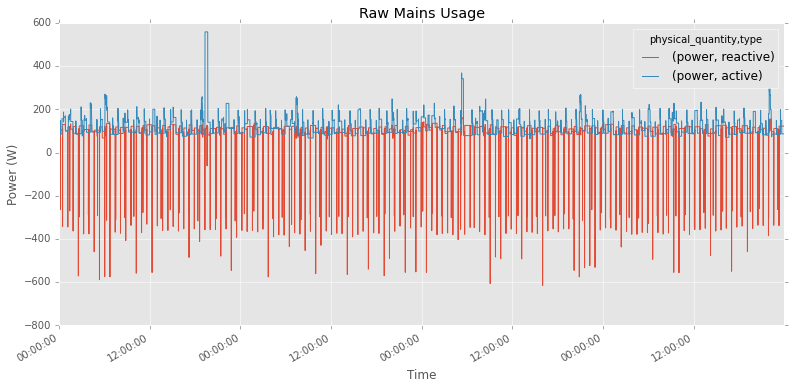

In [5]:
plotdata = df.ix['2015-07-12 00:00:00': '2015-07-16 00:00:00']
plotdata.plot()
plt.title("Raw Mains Usage")
plt.ylabel("Power (W)")
plt.xlabel("Time");

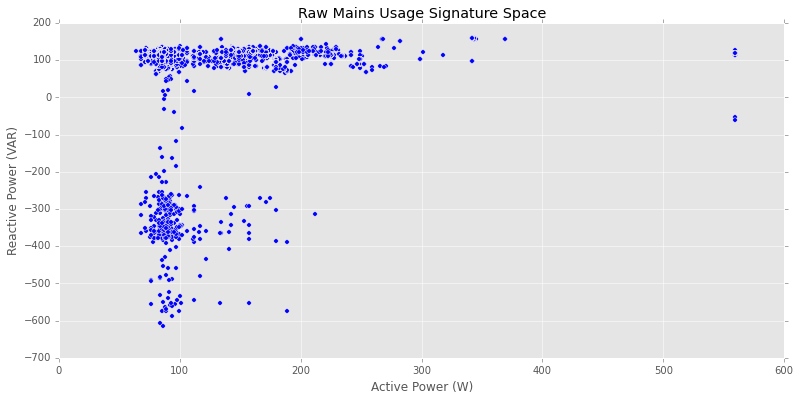

In [6]:
plt.scatter(plotdata[('power','active')],plotdata[('power','reactive')])
plt.title("Raw Mains Usage Signature Space")
plt.ylabel("Reactive Power (VAR)")
plt.xlabel("Active Power (W)");

##Training##
We'll now do the training from the aggregate data. The algorithm segments the time series data into steady and transient states. Thus, we'll first figure out the transient and the steady states. Next, we'll try and pair the on and the off transitions based on their proximity in time and value.

In [17]:
h = Hart85()
h.train(mains,cols=[('power','active'),('power','reactive')],min_tolerance=100,noise_level=70,buffer_size=20,state_threshold=15)


Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.


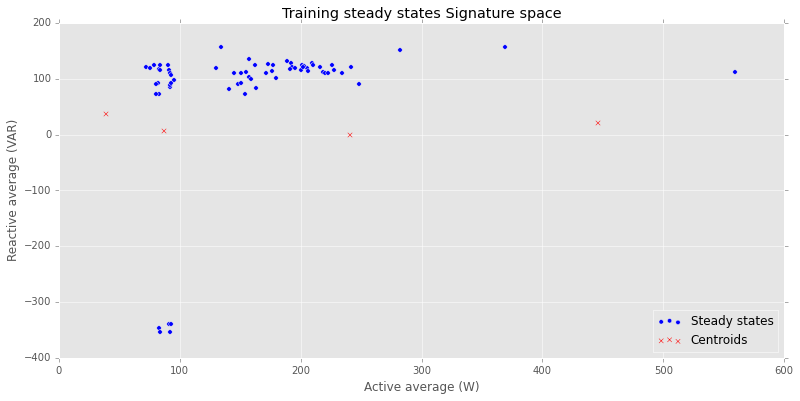

In [21]:
plt.scatter(h.steady_states[('active average')],h.steady_states[('reactive average')])
plt.scatter(h.centroids[('power','active')],h.centroids[('power','reactive')],marker='x',c=(1.0, 0.0, 0.0))
plt.legend(['Steady states','Centroids'],loc=4)
plt.title("Training steady states Signature space")
plt.ylabel("Reactive average (VAR)")
plt.xlabel("Active average (W)");

In [23]:
h.steady_states.head()

,active average,reactive average
2015-07-12 00:24:28+01:00,157.000000,104.019802
2015-07-12 04:09:56+01:00,208.989744,128.000000
2015-07-12 06:05:30+01:00,242.000000,120.400000
2015-07-12 08:44:40+01:00,180.000000,102.000000
2015-07-12 12:26:03+01:00,201.000000,124.998945


In [24]:
h.steady_states.tail()

,active average,reactive average
2015-07-15 15:43:29+01:00,170.993902,110.000000
2015-07-15 18:46:54+01:00,90.000000,125.000000
2015-07-15 19:53:21+01:00,191.000000,117.996146
2015-07-15 20:10:39+01:00,93.000000,92.004858
2015-07-15 22:00:31+01:00,282.000000,151.000000


In [25]:
h.centroids

,"(power, active)","(power, reactive)"
0,87.060310,5.926049
1,240.932203,0.000000
2,39.000000,37.446809
3,446.002135,21.014965


In [26]:
h.model

{}

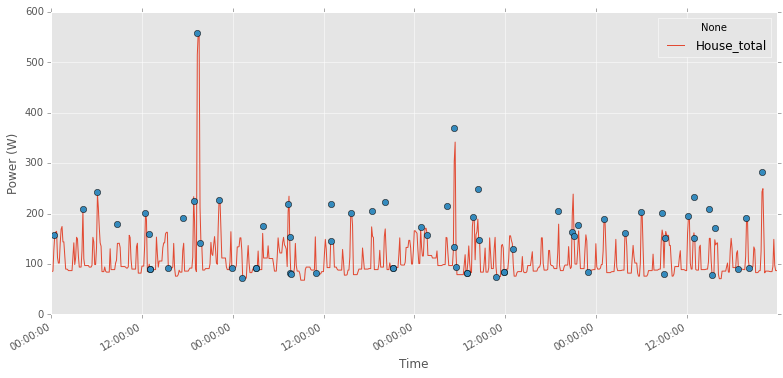

In [27]:
ax = mains.plot()
h.steady_states['active average'].plot(style='o', ax = ax);
plt.ylabel("Power (W)")
plt.xlabel("Time");
#plt.show()

In [14]:
h.pair_df.head()

,T1 Time,T1 Active,T1 Reactive,T2 Time,T2 Active,T2 Reactive
0,2015-07-12 11:26:03,105.000000,1.993097,2015-07-12 22:53:11,-74.967089,-35.964674
1,2015-07-12 17:51:32,73.666667,0.000000,2015-07-13 00:16:57,-80.000000,0.000000
2,2015-07-13 06:21:31,123.400000,-1.600000,2015-07-13 06:37:32,-95.167510,0.000000
3,2015-07-13 06:38:13,71.073171,0.000000,2015-07-13 06:38:31,-74.000000,0.000000
4,2015-07-13 02:58:28,86.944444,0.000000,2015-07-13 10:02:29,-71.838499,-23.829391


In [15]:
pair_shape_df = pd.DataFrame(columns=['Height','Duration'])
pair_shape_df['Height']= (h.pair_df['T1 Active'].abs()+h.pair_df['T2 Active'].abs())/2
pair_shape_df['Duration']= pd.to_timedelta(h.pair_df['T2 Time']-h.pair_df['T1 Time'],unit='s').dt.seconds
pair_shape_df.head()

,Height,Duration
0,89.983544,41228
1,76.833333,23125
2,109.283755,961
3,72.536585,18
4,79.391472,25441


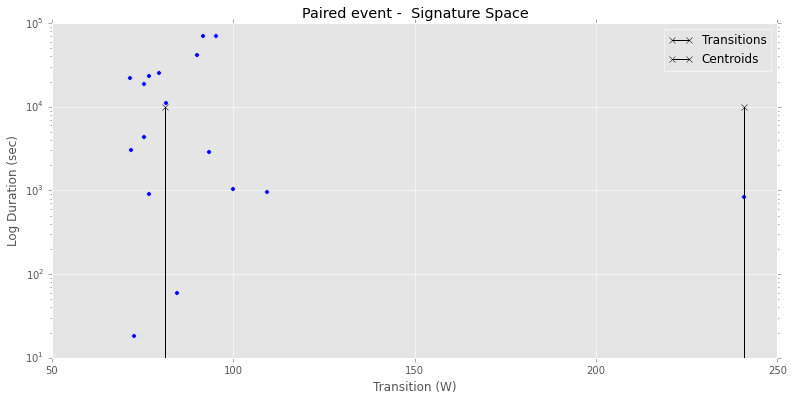

In [16]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1)
ax.set_yscale('log')
ax.scatter(pair_shape_df['Height'],pair_shape_df['Duration'])
#plt.plot((x1, x2), (y1, y2), 'k-')
ax.plot((h.centroids[('power','active')],
        h.centroids[('power','active')]),
        (h.centroids[('power','active')]*0,
         h.centroids[('power','active')]*0+10000)
         ,marker='x',c=(0.0, 0.0, 0.0))
#ax.axvline(h.centroids[('power','active')], color='k', linestyle='--')
plt.legend(['Transitions','Centroids'],loc=1)
plt.title("Paired event -  Signature Space")
plt.ylabel("Log Duration (sec)")
plt.xlabel("Transition (W)");

##Set two days for Disaggregation period of interest##
Inspect the data during a quiet period when we were on holiday, should only be autonomous
appliances such as fidge, freeze and water heating + any standby devices not unplugged. 

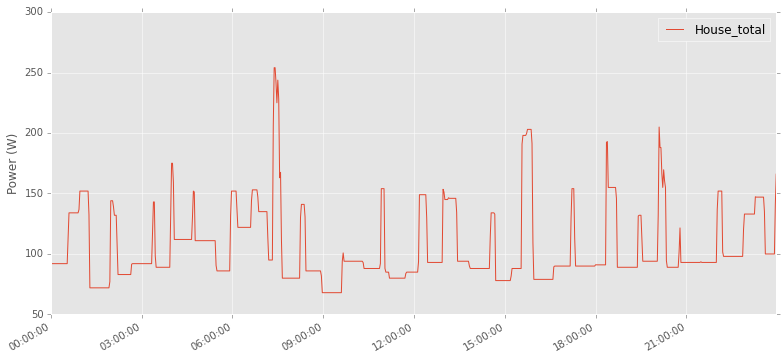

In [15]:
gjw.set_window('2015-07-13 00:00:00','2015-07-14 00:00:00')
elec = gjw.buildings[building_number].elec
mains = elec.mains()
mains.plot()


##Disaggregate using Hart (Active data only)##

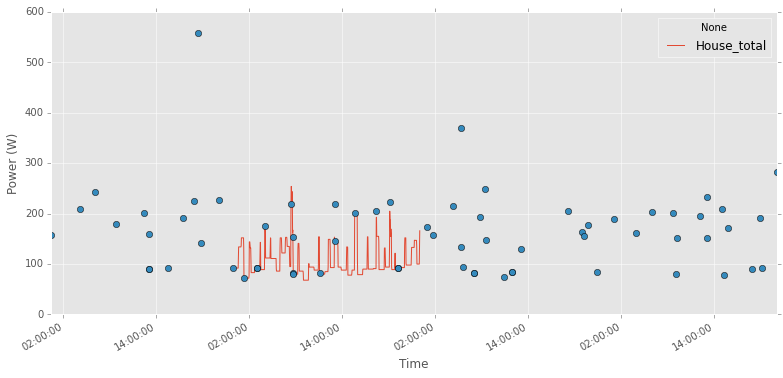

In [16]:
ax = mains.plot()
h.steady_states['active average'].plot(style='o', ax = ax);
plt.ylabel("Power (W)")
plt.xlabel("Time");

In [17]:
disag_filename = join(data_dir, 'disag_gjw_hart.hdf5')
output = HDFDataStore(disag_filename, 'w')
h.disaggregate(mains,output,sample_period=1)
output.close()

Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.


Exception: Data must be 1-dimensional

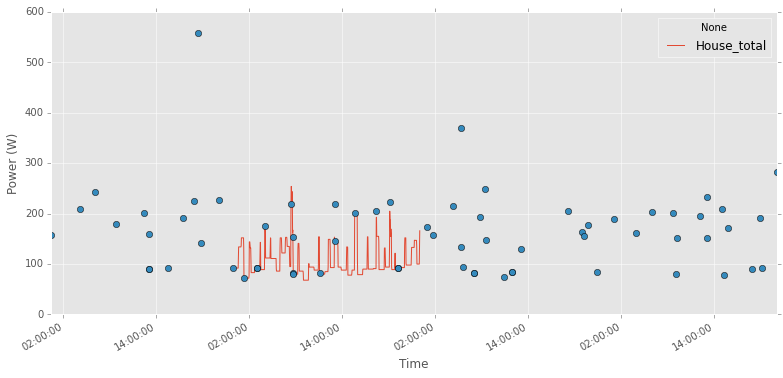

In [18]:
ax = mains.plot()
h.steady_states['active average'].plot(style='o', ax = ax);
plt.ylabel("Power (W)")
plt.xlabel("Time");

In [18]:
disag_hart = DataSet(disag_filename)
disag_hart

In [19]:
disag_hart_elec = disag_hart.buildings[building_number].elec
disag_hart_elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='Hart85_2015-10-07T11:51:36', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='Hart85_2015-10-07T11:51:36', appliances=[Appliance(type='unknown', instance=0)])
  ElecMeter(instance=3, building=1, dataset='Hart85_2015-10-07T11:51:36', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=4, building=1, dataset='Hart85_2015-10-07T11:51:36', appliances=[Appliance(type='unknown', instance=2)])
  ElecMeter(instance=5, building=1, dataset='Hart85_2015-10-07T11:51:36', appliances=[Appliance(type='unknown', instance=3)])
  ElecMeter(instance=6, building=1, dataset='Hart85_2015-10-07T11:51:36', appliances=[Appliance(type='unknown', instance=4)])
  ElecMeter(instance=7, building=1, dataset='Hart85_2015-10-07T11:51:36', appliances=[Appliance(type='unknown', instance=5)])
  ElecMeter(instance=8, building=1, dataset='Hart85_2015-10-07T11:51:36', appliances=[Appliance(type='unknown', instance=6)]

In [20]:
disag_hart_elec.mains()

ElecMeter(instance=1, building=1, dataset='Hart85_2015-10-07T11:51:36', site_meter, appliances=[])

In [21]:
h.centroids

,"(power, active)"
0,164.517390
1,2084.002353
2,2712.309782
3,1276.028081
4,3335.258491
5,4755.483947
6,4078.086616


In [22]:
h.model

{}

In [25]:
h.steady_states

,active average
2015-05-01 00:13:32+01:00,2739.000000
2015-05-01 00:15:24+01:00,1029.034091
2015-05-01 00:26:15+01:00,920.000000
2015-05-01 00:36:18+01:00,645.333333
2015-05-01 00:55:06+01:00,3875.000000
2015-05-01 01:00:30+01:00,703.000000
2015-05-01 01:00:59+01:00,2856.000000
2015-05-01 01:02:26+01:00,3067.318182
2015-05-01 01:06:50+01:00,1009.000000
2015-05-01 01:07:40+01:00,4503.000000


In [17]:
from nilmtk.metrics import f1_score
f1_hart= f1_score(disag_hart_elec, test_elec)
f1_hart.index = disag_hart_elec.get_labels(f1_hart.index)
f1_hart.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('f-score');
plt.title("Hart");

NameError: name 'test_elec' is not defined